# 10. The Jackknife and Bootstrap

* **Jackknife** : a first step toward a computer-based, non-formulatic approach to standard errors 
* **Bootstrap** : toward automating a wide variety of inferential calculations, including standard errors  

In [77]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

from scipy import stats
from random import sample


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

## 10.1 The Jackknife estimate of Standard Errors 

### example 1. kidney data correlation between age and tot (kidney function)

In [2]:
kidney = pd.read_csv("kidney.csv")

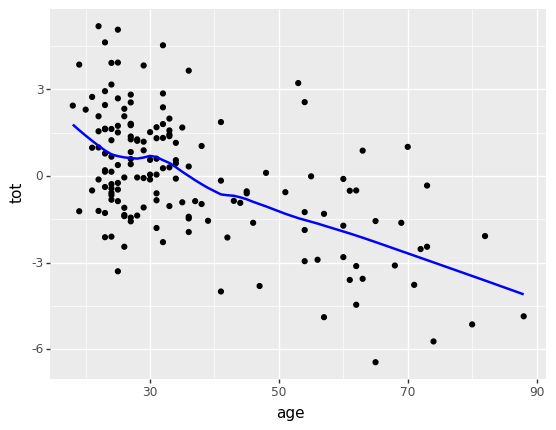

<ggplot: (8770356788119)>

In [16]:
p9.ggplot(kidney, p9.aes(kidney.age, kidney.tot)) + p9.geom_point() + p9.geom_smooth(color="blue", se=True, span=.5)

* 왼쪽에 많은 자료들이 모여있고, 변곡점이 있음을 알 수 있습니다.

In [28]:
theta_hat = kidney.age.corr(kidney.tot) # -0.57, 기존의 correlation 값 

n = kidney.shape[0] ; idx = np.arange(n)
jackknife_all = [kidney.age[idx != i].corr(kidney.tot[idx != i]) for i in range(n)] # i번째 자료를 제외하고 구한 corr

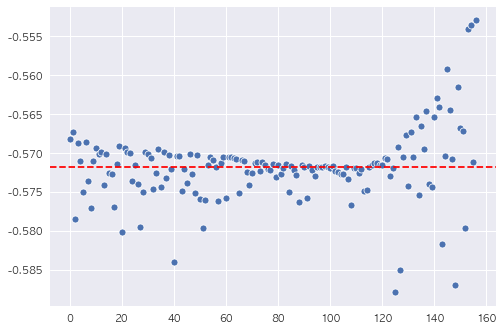

In [33]:
sns.scatterplot(x=idx, y=jackknife_all)
plt.axhline(theta_hat, linestyle = "dashed", color='r')

* 오른쪽의 튀는 점들의 의미는 해당 obs가 크게 영향을 미친다는 것입니다. 이러한 값들을 빼면 corr이 많이 변하게 됩니다. 

In [49]:
se_jack = np.sqrt((n-1)/n * np.sum(np.power((jackknife_all - np.mean(jackknife_all)), 2)))
se_jack

0.058228588552127515

In [54]:
def muhk(h,k) : 
    x = kidney.age ; y=kidney.tot
    return np.mean((x-np.mean(x))**h * (y-np.mean(y))**k)

In [57]:
# taylor series 를 이용해서 대략적으로 계산한 값 
se_taylor = np.sqrt(theta_hat**2 / (4*n) * 
                    (muhk(4,0)/muhk(2,0)**2 + muhk(0,4)/muhk(0,2)**2 +
                     2 * muhk(2,2) / (muhk(2,0) * muhk(0,2)) + 
                     4 * muhk(2,2) / muhk(1,1)**2 - 
                     4 * muhk(3,1) / (muhk(1,1) * muhk(2,0)) - 
                     4 * muhk(1,3) / (muhk(1,1) * muhk(0,2))
                    ))

se_taylor # jackknife 방법으로 계산한 se와 비슷한 결과가 나옵니다 

0.05680082370062839

## 10.2 The Nonparametric Bootstrap 

### example 3. student test eigenratio 

In [60]:
student = pd.read_table("http://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", sep=" ")

In [101]:
n = student.shape[0]; p = student.shape[1]
eigenvalues = np.linalg.eigvals(student.corr()) # eigenvalue 계산 

In [102]:
eigenratio = eigenvalues[0] / sum(eigenvalues) # 전체 변동 중 첫번째 eigenvector가 얼만큼 설명 가능한지 체크하는 지표 
eigenratio

0.6925353153076883

In [80]:
B = 2000 
boot_all = []

for i in range(B) : 
    sampleid = student.sample(n, replace=True) # bootstrap sample, with replacement 
    eigenvalues = np.linalg.eigvals(sampleid.corr())
    boot_all.append(eigenvalues[0] / sum(eigenvalues)) # eigenratio

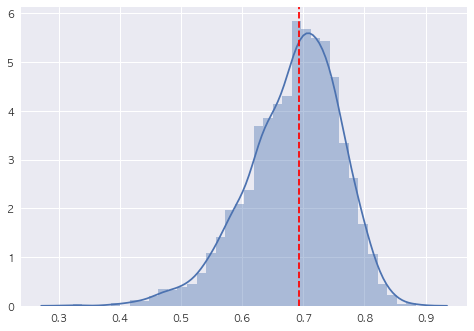

In [84]:
sns.distplot(boot_all)
plt.axvline(eigenratio, linestyle = "dashed", color='r')

In [87]:
np.std(boot_all)

0.07554383687845224

In [96]:
# jackknife 방법 적용 
idx = np.arange(n)
eigenvalues = [np.linalg.eigvals(student[idx != i].corr()) for i in range(n)]
jackknife_all = [e[0] / sum(e) for e in eigenvalues]

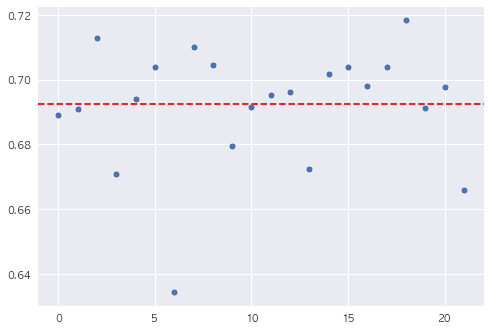

In [103]:
sns.scatterplot(x=idx, y=jackknife_all)
plt.axhline(eigenratio, linestyle = "dashed", color='r')

In [105]:
se_jack = np.sqrt((n-1)/n * np.sum(np.power((jackknife_all - np.mean(jackknife_all)), 2))) ; se_jack # bootstrap 방법보다는 약간 크게 나옵니다 

0.08300211310624513

## 10.3 Resampling Plans 

### example 4. Multisample Bootstrap - AML vs ALL (Fig 10.4) 

In [106]:
leuk = pd.read_csv("http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv")

In [126]:
# 136번 data
ALL = leuk.loc[135, leuk.columns.str.contains("ALL")]
AML = leuk.loc[135, leuk.columns.str.contains("AML")] 

In [127]:
mediff = np.median(AML) - np.median(ALL) ; mediff  # original estimate 

0.23509301599999988

In [131]:
# 각 그룹마다 따로 뽑아서 계산합니다  

B = 500 
boot_all = []

for i in range(B) : 
    ALL_id = ALL.sample(len(ALL), replace=True) # ALL sample, bootstrap 
    AML_id = AML.sample(len(AML), replace=True) # AML sample, bootstrap      
    boot_all.append(np.median(AML_id) - np.median(ALL_id))

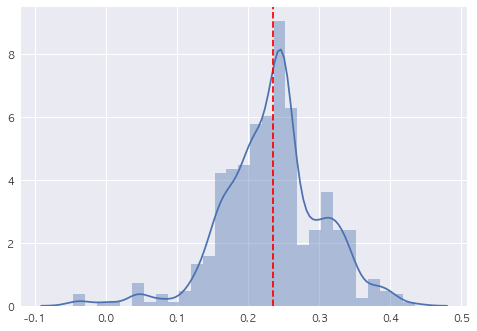

In [133]:
sns.distplot(boot_all)
plt.axvline(mediff, linestyle = "dashed", color='r')

In [134]:
np.std(boot_all)

0.06913674071319166

## 10.4 The Parametric Bootstrap 

### example 6. student score eigenratio calculation 

In [135]:
student = pd.read_table("http://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", sep=" ")

In [136]:
n = student.shape[0]; p = student.shape[1]
eigenvalues = np.linalg.eigvals(student.corr()) # eigenvalue 
eigenratio = eigenvalues[0] / sum(eigenvalues) # eigenratio
eigenratio

0.6925353153076883

In [149]:
meanS = student.mean(axis=0)  ; varS = np.cov(student.T)
cholS = np.linalg.cholesky(varS) # Cholesky decomposition : A = LL' -> LZ+Mu, 5개의 score가 Multivariate Normal 따른다고 가정 

In [216]:
B = 2000 
boot_all = []

for i in range(B) : 
    bootS = stats.norm.rvs(0,1,n*p).reshape(-1,5) @ cholS + np.ones((1,n)).reshape(-1,1) @ np.array(meanS).reshape(1,-1)
    eigenvalues = np.linalg.eigvals(pd.DataFrame(bootS).corr())
    boot_all.append(eigenvalues[0] / sum(eigenvalues))

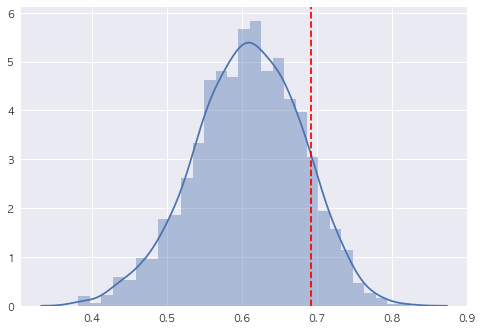

In [217]:
sns.distplot(boot_all)
plt.axvline(eigenratio, linestyle = "dashed", color='r')

In [218]:
np.std(boot_all)

0.071287830454689